# Statistical properties of the promoter library
## Introduction

The statistical analysis generates visualizations for sequence specific properties like the histogram of sequence distance with respect to nucleotide exchanges, and the diversity of position specific sampling using entropy. The expression for the expression is given by a histogram of the expression strength distribution. The joint information of sequence and expression is visualized with heat-maps on average and variance of expression.

The visualizations are stored in a subdirectory with a naming corresponding to the input file, see 'config.txt'.

---

**Author: Ulf W. Liebal** <br>
**Contact: ulf.liebal@rwth-aachen.de** <br>

---

## System initiation

Loading all necessary libraries.

In [1]:
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ExpressionExpert_Functions import Data_Src_Load, make_DataDir, ExpressionScaler, Sequence_Conserved_Adjusted, Insert_row_, ExpressionStrength_HeatMap, df_HeatMaps, ExpressionVariation_HeatMap, Sequence_Ref_DiffSum, Sequence_Dist_DiffSum
%matplotlib inline

### Variable setting

We load the naming conventions from 'config.txt'

In [2]:
Name_Dict = dict()
with open('config_Pput.txt') as Conf:
    myline = Conf.read().splitlines()
    for line in myline:
        if not line.startswith('#'):
            (key, val) = line.split(':', 1)
            Name_Dict[str(key.strip())] = val.strip()
        

Data_File = Name_Dict['Data_File']
# extract the filename for naming of newly generated files
File_Base = Name_Dict['File_Base']
# the generated files will be stored in a subfolder with custom name
Data_Folder = Name_Dict['Data_Folder']
# column name of expression values
Y_Col_Name = eval(Name_Dict['Y_Col_Name'])
# figure file type
Fig_Type = Name_Dict['Figure_Type']
make_DataDir(Name_Dict)

Already existent data directory  data-Example1-Pput .


## Data loading

General information on the data source csv-file is stored in the 'config.txt' file generated in the '0-Workflow' notebook. The sequence and expression data is stored in a csv file with an identifier in column 'ID' (not used for anything), the DNA-sequence in column 'Sequence', and the expression strength in column 'promoter activity'. While loading, the sequence is converted to a label encrypted sequence, ['A','C','G','T'] replaced by [0,1,2,3], and a one-hot encoding.

In [3]:
SeqDat = Data_Src_Load(Name_Dict)
SeqDat['Sequence_letter-encrypted'] = SeqDat['Sequence_letter-encrypted'].str.upper()
SeqDat.head(3)

,Strain ID,Sequence,Promoter Activity,Sequence_label-encrypted,Sequence_letter-encrypted
0,BG14g,"[[0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0,...",35.057893,"[2, 1, 1, 1, 0, 3, 3, 2, 0, 1, 0, 0, 2, 2, 1, ...",GCCCATTGACAAGGCTCTCGCGGCCAGGTATAATTGCACG
1,BG14g,"[[0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0,...",33.579982,"[2, 1, 1, 1, 0, 3, 3, 2, 0, 1, 0, 0, 2, 2, 1, ...",GCCCATTGACAAGGCTCTCGCGGCCAGGTATAATTGCACG
2,BG14g,"[[0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0,...",31.523439,"[2, 1, 1, 1, 0, 3, 3, 2, 0, 1, 0, 0, 2, 2, 1, ...",GCCCATTGACAAGGCTCTCGCGGCCAGGTATAATTGCACG


## Data manipulation

Data manipulation includes the steps of expression standardization to zero mean and unit variance. On each position the entropy is calculated to assess how much nucleotide diversity has been sampled on each position. If at any position the entropy is zero, i.e. only one nucleotide is present in all samples, this position is removed because it is non-informative for further analysis (Position entropy analysis). 

### Normalization of variables

In [4]:
SeqDat, Expr_Scaler_new = ExpressionScaler(SeqDat, Name_Dict)

### Position entropy analysis

In [5]:
# removing non-informative positions where no base diversity exists, base one hot encoding
SeqDat_Hadj, Positions_removed, PSEntropy = Sequence_Conserved_Adjusted(SeqDat, Name_Dict)

## Visualization of statistical properties

The standardized expression is used for visualization of the average and variance of expression for each nucleotide on each position (Heat map visualization of nucleotide-position expression). A histogram of the sequence differences is generated. Here, the frequency of sequences with a given number of nucleotide exchanges (in %) relative to the first sequence is plotted (Histogram of sequence distances). The sampled nucleotide diversity on each sequence position is plotted (Position entropy lollipop). A histogram showing the number of sequences over the expression range with a binning of ten is shown (Expression strength histogram).

### Heat map visualization of nucleotide-position expression

The heat maps are visualized only and not saved. Visualization of variation is suppressed.

Z:\Documents\Biocarb\models\data\1911_ExpressionExpert.ipynb\ExpressionExpert_Functions.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df1.loc[idx]=element


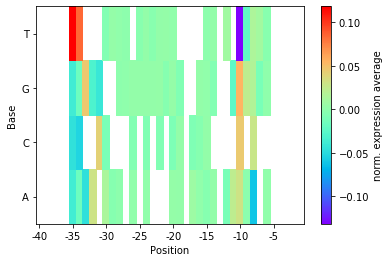

In [6]:
# we loop over all independent expression measurements
for idx in range(int(Name_Dict['Library_Expression'])):
    Measure_Name = Y_Col_Name[idx]
    Expression_Column = '{}_scaled'.format(Measure_Name)
# # removing non-informative positions where no base diversity exists, base one hot encoding
    Expr_avg = ExpressionStrength_HeatMap(SeqDat_Hadj, Expression_Column)
    Expr_avg = Insert_row_(Positions_removed, Expr_avg, np.zeros([len(Positions_removed),4])*np.nan)
# visualization of variation is commented
#     Expr_var_Pput = ExpressionVariation_HeatMap(SeqDat_Hadj, Expression_Column)
#     Expr_var_Pput = Insert_row_(Positions_removed, Expr_var_Pput, np.zeros([len(Positions_removed),4])*np.nan)
    Fig_ID = Name_Dict['HM_File']
    HM_File = os.path.join(Data_Folder, '{}_{}_{}_{}_{{}}.{}'.format(time.strftime('%Y%m%d'), File_Base, Fig_ID, Measure_Name.replace(' ',''), Fig_Type))   

    # if you want to store the heat-maps switch the argument 'False' to 'True'
    df_HeatMaps(Expr_avg, 'norm. expression average', True, HM_File.format('Average'))
#     df_HeatMaps(Expr_var_Pput, 'norm. expression variance', False, HM_File.format('Variance'))


### Histogram of sequence distances

The histograms can be calculated in two ways:
 * sequence distances relative to a reference sequence
 * sequence distances among all sequences
The sequence distance relative to a reference sequence makes sense if the library is generated from a single reference promoter set-up. The calculation is fast. If the library is very heterogeneous and different reference promoters have been used, then it is more appropriate to compare all sequences against each other to identify the overall sampled sequence diversity. The occurence takes high values because all sequences are mutually paired. This takes longer to compute (still less than a minute for fewer than 1000 samples of sequence length 50).

**User input:** <br>
 * Decision for sequence distance with respect to reference seuqence or among all sequences.
 * Optional decision of saving the histogram by uncommenting the 'savefig' command.
 
*Example:*<br>
In the *P. putida* example, a single reference promoter sequence is used. Therefore, the reference based sequence distance meter is appropriate:<br>
mydist = Sequence_Ref_DiffSum(SeqDat['Sequence_letter-encrypted'])

A generic file name for figure export is set, but figure-export to svg is commented.


Distance reference sequence: GCCCATTGACAAGGCTCTCGCGGCCAGGTATAATTGCACG


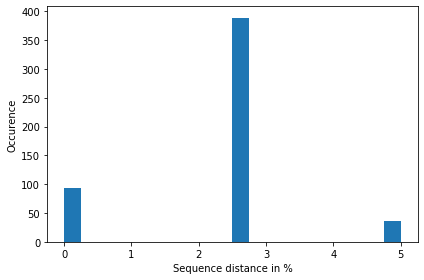

In [7]:
# For histogram of sequence diversity you can either root the distance to the most common nucleotide on each position or provide an external reference
if Name_Dict['RefSeq'] is not '':
    RefSeq = Name_Dict['RefSeq']
    print('use reference sequence')
else:    
    # using the one-hot encoding the most common nucleotide on each position is calculated.
    Alphabet = ['A','C','G','T']
    Pos_Nucl_Sum = np.sum(np.dstack(SeqDat['Sequence'].values), axis=2)
    RefSeq_list = list([Alphabet[Pos_idx] for Pos_idx in np.argmax(Pos_Nucl_Sum, axis=1)])
    RefSeq = ''.join(RefSeq_list)

print('Distance reference sequence:', RefSeq)
SeqDat_wRef = list(SeqDat['Sequence_letter-encrypted'])
SeqDat_wRef.insert(0, RefSeq)

dist_tmp = Sequence_Ref_DiffSum(SeqDat_wRef)
if len(dist_tmp.shape) == 2:
    mydist = dist_tmp[np.triu_indices(dist_tmp.shape[1], k=1)]
else:
    mydist = dist_tmp
    
# plt.rc('text', usetex=False)
plt.hist(mydist*100, bins=20) # BG42: [3,6:221]; BG35:[2,222:]
plt.xlabel('Sequence distance in %')
plt.ylabel('Occurence')
plt.tight_layout()
Fig_ID = Name_Dict['SampSeqDist_File']
SampSeqDist_File = os.path.join(Data_Folder, '{}_{}_{}.{}'.format(time.strftime('%Y%m%d'), File_Base, Fig_ID, Fig_Type))
plt.savefig(SampSeqDist_File, bbox_inches='tight', format=Fig_Type)
plt.show()

### Position sampling and entropy lollipop

**User input:** <br>
 * Optional decision of saving the histogram by uncommenting the 'savefig' command.


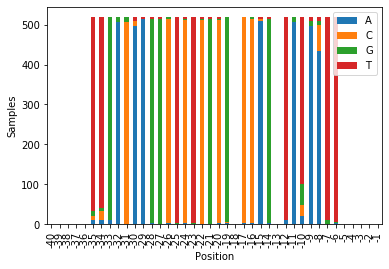

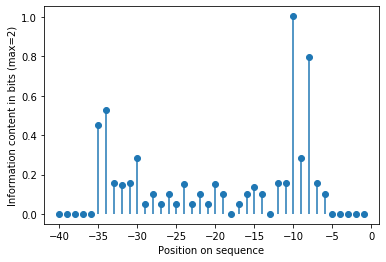

In [8]:
OH_matrix = np.stack(SeqDat_Hadj['OneHot'].values)
OH_df = pd.DataFrame(np.sum(OH_matrix, axis=0), columns=['A','C','G','T'])
OH_df = Insert_row_(Positions_removed, OH_df, np.zeros([len(Positions_removed),4]))
OH_df[['A','C','G','T']].plot(kind='bar', stacked=True)
plt.xlabel('Position')
plt.ylabel('Samples')
Fig_ID = Name_Dict['SamplingDiv_File']
SamplingDiv_File = os.path.join(Data_Folder, '{}_{}_{}.{}'.format(time.strftime('%Y%m%d'), File_Base, Fig_ID, Fig_Type))
plt.savefig(SamplingDiv_File, bbox_inches='tight', format=Fig_Type)
plt.show()

plt.stem(np.arange(-len(PSEntropy),0,1), PSEntropy, basefmt=' ', use_line_collection=True)
plt.xlabel('Position on sequence')
plt.ylabel('Information content in bits (max=2)')
Fig_ID = Name_Dict['Entropy_File']
Entropy_File = os.path.join(Data_Folder, '{}_{}_{}.{}'.format(time.strftime('%Y%m%d'), File_Base, Fig_ID, Fig_Type))
# plt.savefig(Entropy_File, bbox_inches='tight', format=Fig_Type)
plt.show()

### Expression strength histogram

**User input:** <br>
 * Optional decision of saving the histogram by uncommenting the 'savefig' command.


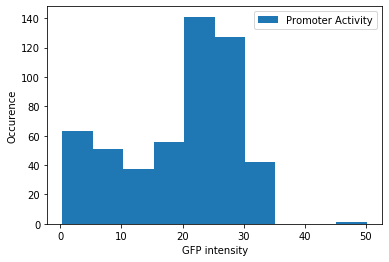

In [9]:
plt.hist(SeqDat[Y_Col_Name].values)
plt.xlabel(Name_Dict['Expression_Unit'])
plt.ylabel('Occurence')
plt.legend(Y_Col_Name)
Fig_ID = Name_Dict['ExprHist_File']
ExprHist_File = os.path.join(Data_Folder, '{}_{}_{}.{}'.format(time.strftime('%Y%m%d'), File_Base, Fig_ID, Fig_Type))
# plt.savefig(ExprHist_File, bbox_inches='tight', format=Fig_Type)
plt.show()

## Promoter cross-host expression (optional)

In case the promoter library was constructed such that a sequence library was tested in different organisms (transcription factors) then it is instructive to compare cross-host (cross-transcription factor) expression strength. Here, this is only done for two measurements.

In [ ]:
if len(Y_Col_Name) == 2:
    ExprRange_1 = SeqDat[Y_Col_Name[0]]#/SeqDat[Y_Col_Name[0]].max()*100
    ExprRange_2 = SeqDat[Y_Col_Name[1]]#/SeqDat[Y_Col_Name[1]].max()*100

    fig = plt.figure()
#     ax = fig.gca()
#     ax.set_xticks(np.arange(0, 100, 10))
#     ax.set_yticks(np.arange(0, 100, 10))


    plt.plot(ExprRange_1, ExprRange_2, 'xk')
    plt.xlabel('{}, in {}'.format(Y_Col_Name[0], Name_Dict['Expression_Unit']))
    plt.ylabel('{}, in {}'.format(Y_Col_Name[1], Name_Dict['Expression_Unit']))
    plt.title('Cross Expression Translation')
    plt.grid()
    plt.tight_layout()
    Fig_ID = Name_Dict['X_Expr']
    XExpr_File = os.path.join(Data_Folder, '{}_{}_{}.{}'.format(time.strftime('%Y%m%d'), File_Base, Fig_ID, Fig_Type))
    plt.savefig(XExpr_File, bbox_inches='tight', format=Fig_Type)
    plt.show()